## Introduction

Research Question: How does the level of debt owed to the World Bank, intellectual property, and balance of payments correlate with the GDP growth rates of countries, and are there distinguishable patterns or differences in this relationship when comparing developed and developing nations?

Our project aims to research the relationship between a Country’s GDP and their debt to the World Bank Group and the International Monetary Fund. The World Bank’s mission is to “end extreme poverty and promote shared prosperity in a sustainable way” (World Bank Group, 2023). However, there is extreme controversy on whether their involvement in developing countries’ economic development is positive or exploitative (Nagle, 2019). Seeing whether there is a relationship between a country’s economic prosperity (measured by GDP) and the pattern of loans("Borrower's Obligation") received from these Multi-Governmental Organizations would provide an interesting insight into whether countries's economic livelihood is more negatively affected by the involvement of these MGOs. There is detailed and immensely available data that correlates to this topic because there is information on GDP and Debt for all countries, also broken down by developing versus developed countries. 


## Data Description
We have four data tables for this phase: The GDP data for countries around the world, Loans/debt owed to the World Bank by countries, a dataset containing a list of developed countries (as classified biy the UN), and the Intellectual Property of countries for years 2000 to 2022.

The GDP Dataset details the gross domestic product for individual countries across a set of years. Specifically, the dataset contains years from 1960 to 2022 with the respective GDPs - in USD dollars - for 267 countries around the world.

The loans/debt dataset discusses a given amount of money loaned to a country from the World Bank and what how that money has been handled since. This particular dataset contains 148 countries and their original principal amount,canceled amount, undisbursed amount, disbursed amount, and borrower's obligation.

For the intellectual property dataset it pertains to transactions between residents and non-residents concerning the authorized utilization of intellectual property rights. This encompasses rights like patents, trademarks, copyrights, industrial designs, trade secrets, and franchises. Additionally, it covers the usage of original productions or prototypes, which include copyrights on literature, software, films, and audio recordings, as well as associated rights for live events and various broadcast methods. The monetary values provided in the dataset are presented in contemporary U.S. dollars (World Bank, 2023). 

There is also a datset containing developed countries based on the United Nations classification. This is going to be used to compare if there are any patterns or trends with the dependent variables discussed previously and developing and developed nations.

Link to balance of payments of countries owed to World Bank: https://finances.worldbank.org/Loans-and-Credits/IBRD-Country-wise-Loan-summary/5xqk-t59j

Link to intellectual property: https://data.worldbank.org/indicator/BM.GSR.ROYL.CD?locations=SV

Link to GDP: https://data.worldbank.org/indicator/NY.GDP.MKTP.CD?end=2022&start=2022&view=bar

Link to Developed Countries Dataset: https://worldpopulationreview.com/country-rankings/developed-countries


## Preregistration of Analyses

Hypothesis 1: If a country’s borrower's obligation is greater, then they will be more likely to be a developed country. 

Analysis: We will conduct a logistic regression where we output whether or not a country is developed or developing (a dummy variable) based on an input of the borrower’s obligation (in USD dollars). The developed country dummy will be the reference variable, so we will test whether $e^\beta$, where $\beta$ is the coefficient output by the regression equation for the 'Borrower's Obligation' variable, is greater than 1. The reason this analysis is important is because 

Hypothesis 2: The higher a country’s GDP (in USD Dollars), the higher the intellectual property charges (in USD Dollars). 

Analysis: We will conduct a linear regression where we input the GDP of a country and output the intellectual property charges. We would test whether  (the regression coefficient of GDP in our equation) is greater than 0 (if an increase in GDP causes an increase in Intellectual Property Charges). 


## Data Cleaning 

In [30]:
import pandas as pd
import numpy as np
import math as math

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from scipy import stats

import duckdb

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm 

In [31]:
int_property_df = pd.read_csv("Intellectual_Property_Table.csv")
gdp_df = pd.read_csv("GDP_Table.csv", delimiter = ",")
debt_df = pd.read_csv("IBRD_Country-wise_Loan_summary.csv")
developed_countries_df = pd.read_csv("developed-countries-2023.csv")

In [32]:
print("Intellectual Property dataframe shape" + str(int_property_df.shape))
print("GDP dataframe shape" + str(gdp_df.shape))
print("Debt dataframe shape" + str(debt_df.shape))
print("Developed Countries dataframe shape" + str(developed_countries_df.shape))


Intellectual Property dataframe shape(271, 67)
GDP dataframe shape(266, 67)
Debt dataframe shape(147, 6)
Developed Countries dataframe shape(66, 3)


In [33]:
#years we do not want to consider
unwanted_years = ['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967',
                  '1968','1969', '1970', '1971', '1972', '1973', '1974', '1975', 
                  '1976', '1977','1978', '1979', '1980', '1981', '1982', '1983', 
                  '1984', '1985', '1986','1987', '1988', '1989', '1990', '1991', 
                  '1992', '1993', '1994', '1995','1996', '1997', '1998', '1999']

#reducing GDP dataframe, saving to new csv
filtered_gdp_df = gdp_df.drop(columns=unwanted_years)
print("New GDP DF Columns:" + str(filtered_gdp_df.columns))

#saving to new csv file
filtered_gdp_df.to_csv("Filtered_GDP.csv", index=False)

#reducing Intellectual Property dataframe, saving to new csv
filtered_int_prop_df = int_property_df.drop(columns=unwanted_years)
print("New Intellectual Property DF Columns:" + str(filtered_int_prop_df.columns))

#saving to new csv file
filtered_int_prop_df.to_csv("Filtered_Int_Prop.csv", index=False)

New GDP DF Columns:Index(['Country_Name', 'Country_Code', 'Indicator_Name', 'Indicator_Code',
       '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', '2019', '2020', '2021', '2022'],
      dtype='object')
New Intellectual Property DF Columns:Index(['Country_Name', 'Country_Code', 'Series_Name', 'Series_Code', '2000',
       '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
       '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
       '2019', '2020', '2021', '2022'],
      dtype='object')


In [34]:
#dropping year columns containing HDI values
developed_countries_df = developed_countries_df.drop(
    columns = ['Hdi2021','Hdi2020'])

#adding column of all ones
developed_countries_df['developed'] = 1

developed_countries_df.head(10)

,country,developed
0,Switzerland,1
1,Norway,1
2,Iceland,1
3,Hong Kong,1
4,Australia,1
5,Denmark,1
6,Sweden,1
7,Ireland,1
8,Germany,1
9,Netherlands,1


In [35]:
print("GDP df datatypes\n" + str(filtered_gdp_df.dtypes))
print("Intellectual Property df datatypes\n" + str(filtered_int_prop_df.dtypes))
print("Debt df datatypes\n" + str(debt_df.dtypes))
print("Developed Countries datatypes\n" + str(developed_countries_df.dtypes))

GDP df datatypes
Country_Name       object
Country_Code       object
Indicator_Name     object
Indicator_Code     object
2000              float64
2001              float64
2002              float64
2003              float64
2004              float64
2005              float64
2006              float64
2007              float64
2008              float64
2009              float64
2010              float64
2011              float64
2012              float64
2013              float64
2014              float64
2015              float64
2016              float64
2017              float64
2018              float64
2019              float64
2020              float64
2021              float64
2022              float64
dtype: object
Intellectual Property df datatypes
Country_Name    object
Country_Code    object
Series_Name     object
Series_Code     object
2000            object
2001            object
2002            object
2003            object
2004            object
2005            object
20

In [36]:
#Fill nans in GDB and Intellectual Property dataframes with 0
filtered_gdp_df.replace(np.nan, 0.0, inplace=True)
filtered_gdp_df.replace("..", 0.0, inplace=True)

filtered_int_prop_df.replace(np.nan, 0.0, inplace=True)
filtered_int_prop_df.replace("..", 0.0, inplace=True)

In [37]:
#inner joining GDP df on Debt df
gdp_debt_df = duckdb.sql("""SELECT * FROM
                         debt_df INNER JOIN filtered_gdp_df
                         ON 
                         debt_df.Country 
                         = filtered_gdp_df.Country_Name""").df()

#Dropping the redundant Country_Name column
gdp_debt_df = gdp_debt_df.drop("Country_Name", axis = 1)

#inner joining Intellectual Property df on Debt df
int_property_debt_df = duckdb.sql("""SELECT * FROM
                         debt_df INNER JOIN filtered_int_prop_df
                         ON 
                         debt_df.Country 
                         = filtered_int_prop_df.Country_Name""").df()

#Dropping the redundant Country_Name column
int_property_debt_df = int_property_debt_df.drop("Country_Name", axis = 1)

print(gdp_debt_df.head(5))
print(int_property_debt_df.head(5))

               Country  Original Principal Amount  Cancelled Amount  \
0              Albania               2.032160e+09      1.402591e+08   
1            Argentina               4.246665e+10      4.680851e+09   
2              Armenia               1.224900e+09      4.430277e+07   
3  Antigua and Barbuda               1.200000e+07      7.435746e+06   
4            Australia               4.177300e+08      0.000000e+00   

   Undisbursed Amount  Disbursed Amount  Borrower's Obligation Country_Code  \
0        7.465856e+08      1.082344e+09           8.740135e+08          ALB   
1        5.289592e+09      3.300022e+10           9.498279e+09          ARG   
2        1.301590e+08      1.053062e+09           9.671751e+08          ARM   
3        5.161400e+04      4.512640e+06           4.012867e+06          ATG   
4        0.000000e+00      4.177300e+08          -2.000000e-02          AUS   

      Indicator_Name  Indicator_Code          2000  ...          2013  \
0  GDP (current US$)  NY.

In [38]:
#adding developed countries df to gdp_debt_df
gdp_dbt_dev_df = duckdb.sql("""SELECT * FROM
                         gdp_debt_df LEFT JOIN developed_countries_df
                         ON gdp_debt_df.Country 
                         = developed_countries_df.country""").df()

gdp_dbt_dev_df = gdp_dbt_dev_df.drop(columns = 'country')

#adding developed countries df to int_prop_dbt_dev_df
int_prop_dbt_dev_df = duckdb.sql("""SELECT * FROM
                         int_property_debt_df LEFT JOIN developed_countries_df
                         ON int_property_debt_df.Country 
                         = developed_countries_df.country""").df()

int_prop_dbt_dev_df = int_prop_dbt_dev_df.drop(columns = 'country')

print(gdp_dbt_dev_df.head(5))
print(int_prop_dbt_dev_df.head(5))

               Country  Original Principal Amount  Cancelled Amount  \
0              Albania               2.032160e+09      1.402591e+08   
1              Armenia               1.224900e+09      4.430277e+07   
2  Antigua and Barbuda               1.200000e+07      7.435746e+06   
3           Azerbaijan               3.479300e+09      5.324351e+08   
4              Burundi               4.800000e+06      0.000000e+00   

   Undisbursed Amount  Disbursed Amount  Borrower's Obligation Country_Code  \
0         746585590.2      1.082344e+09           8.740135e+08          ALB   
1         130159016.0      1.053062e+09           9.671751e+08          ARM   
2             51614.0      4.512640e+06           4.012867e+06          ATG   
3         108026863.4      2.838838e+09           1.250364e+09          AZE   
4                 0.0      4.800000e+06           0.000000e+00          BDI   

      Indicator_Name  Indicator_Code          2000  ...          2014  \
0  GDP (current US$)  NY.

In [39]:
#filling NaN values in 'developed' columns of both dataframes with 0
gdp_dbt_dev_df['developed'].replace(np.nan, value= 0, inplace = True)
int_prop_dbt_dev_df['developed'].replace(np.nan, value= 0, inplace = True)


int_prop_dbt_dev_df.to_csv("Int_Prop_Debt_Combined.csv", index=False)
gdp_dbt_dev_df.to_csv("GDP_Debt_Combined.csv", index=False)


print(gdp_dbt_dev_df.head(5))
print(int_prop_dbt_dev_df.head(5))

               Country  Original Principal Amount  Cancelled Amount  \
0              Albania               2.032160e+09      1.402591e+08   
1              Armenia               1.224900e+09      4.430277e+07   
2  Antigua and Barbuda               1.200000e+07      7.435746e+06   
3           Azerbaijan               3.479300e+09      5.324351e+08   
4              Burundi               4.800000e+06      0.000000e+00   

   Undisbursed Amount  Disbursed Amount  Borrower's Obligation Country_Code  \
0         746585590.2      1.082344e+09           8.740135e+08          ALB   
1         130159016.0      1.053062e+09           9.671751e+08          ARM   
2             51614.0      4.512640e+06           4.012867e+06          ATG   
3         108026863.4      2.838838e+09           1.250364e+09          AZE   
4                 0.0      4.800000e+06           0.000000e+00          BDI   

      Indicator_Name  Indicator_Code          2000  ...          2014  \
0  GDP (current US$)  NY.

In [40]:
print(int_prop_dbt_dev_df.dtypes)
print(gdp_dbt_dev_df.dtypes)

Country                       object
Original Principal Amount    float64
Cancelled Amount             float64
Undisbursed Amount           float64
Disbursed Amount             float64
Borrower's Obligation        float64
Country_Code                  object
Series_Name                   object
Series_Code                   object
2000                          object
2001                          object
2002                          object
2003                          object
2004                          object
2005                          object
2006                          object
2007                          object
2008                          object
2009                          object
2010                          object
2011                          object
2012                          object
2013                          object
2014                          object
2015                          object
2016                          object
2017                          object
2

In [41]:
cols_to_fix = ['2000', '2001', '2002',
       '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
       '2021', '2022']

for col in cols_to_fix:
  int_prop_dbt_dev_df[col] = int_prop_dbt_dev_df[col].astype(np.float64)

## Data Analysis

In [42]:
#checking the columns existing in the df to conduct the data analysis
print(gdp_dbt_dev_df.columns)

Index(['Country', 'Original Principal Amount', 'Cancelled Amount',
       'Undisbursed Amount', 'Disbursed Amount', 'Borrower's Obligation',
       'Country_Code', 'Indicator_Name', 'Indicator_Code', '2000', '2001',
       '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020', '2021', '2022', 'developed'],
      dtype='object')


In [43]:
#collecting the summary statistics related to GDP & Debt
print(gdp_dbt_dev_df.describe(include='all'))

        Country  Original Principal Amount  Cancelled Amount  \
count       135               1.350000e+02      1.350000e+02   
unique      135                        NaN               NaN   
top     Albania                        NaN               NaN   
freq          1                        NaN               NaN   
mean        NaN               6.013611e+09      7.263827e+08   
std         NaN               1.405140e+10      1.819805e+09   
min         NaN               2.600000e+06      0.000000e+00   
25%         NaN               1.455000e+08      2.941172e+06   
50%         NaN               6.260000e+08      6.564928e+07   
75%         NaN               4.227310e+09      4.828613e+08   
max         NaN               7.918036e+10      1.390867e+10   

        Undisbursed Amount  Disbursed Amount  Borrower's Obligation  \
count         1.350000e+02      1.350000e+02           1.350000e+02   
unique                 NaN               NaN                    NaN   
top               

In [44]:
#collecting the summary statistics related to Intellectual Property & Debt
print(int_prop_dbt_dev_df.describe(include='all'))

        Country  Original Principal Amount  Cancelled Amount  \
count       135               1.350000e+02      1.350000e+02   
unique      135                        NaN               NaN   
top     Albania                        NaN               NaN   
freq          1                        NaN               NaN   
mean        NaN               6.013611e+09      7.263827e+08   
std         NaN               1.405140e+10      1.819805e+09   
min         NaN               2.600000e+06      0.000000e+00   
25%         NaN               1.455000e+08      2.941172e+06   
50%         NaN               6.260000e+08      6.564928e+07   
75%         NaN               4.227310e+09      4.828613e+08   
max         NaN               7.918036e+10      1.390867e+10   

        Undisbursed Amount  Disbursed Amount  Borrower's Obligation  \
count         1.350000e+02      1.350000e+02           1.350000e+02   
unique                 NaN               NaN                    NaN   
top               

## Preregistration of Hypotheses

Hypothesis 1: If a country’s borrower's obligation is greater, then they will be more likely to be a developed country. 

Analysis: We will conduct a logistic regression where we output whether or not a country is developed or developing (a dummy variable) based on an input of the borrower’s obligation (in USD dollars). The developed country dummy will be the reference variable, so we will test whether $e^\beta$, where $\beta$ is the coefficient output by the regression equation for the 'Borrower's Obligation' variable, is greater than 1.

Hypothesis 2: The higher a country’s GDP (in USD Dollars), the higher the intellectual property charges (in USD Dollars). 

Analysis: We will conduct a linear regression where we input the GDP of a country and output the intellectual property charges. We would test whether  (the regression coefficient of GDP in our equation) is greater than 0 (if an increase in GDP causes an increase in Intellectual Property Charges). 


### Hypothesis 1: A Higher Borrower's Obligation Implies That a Country is More Likely to be Developed

In [45]:
#loading in cleaned csv from phase 2 (gdp data, debt data, and developed binary
#variable)

gdp_debt_csv = pd.read_csv("./GDP_Debt_Combined.csv")
print(gdp_debt_csv.head(2))

   Country  Original Principal Amount  Cancelled Amount  Undisbursed Amount  \
0  Albania               2.032160e+09      1.402591e+08         746585590.2   
1  Armenia               1.224900e+09      4.430277e+07         130159016.0   

   Disbursed Amount  Borrower's Obligation Country_Code     Indicator_Name  \
0      1.082344e+09            874013475.8          ALB  GDP (current US$)   
1      1.053062e+09            967175073.4          ARM  GDP (current US$)   

   Indicator_Code          2000  ...          2014          2015  \
0  NY.GDP.MKTP.CD  3.480355e+09  ...  1.322815e+10  1.138685e+10   
1  NY.GDP.MKTP.CD  1.911564e+09  ...  1.160951e+10  1.055334e+10   

           2016          2017          2018          2019          2020  \
0  1.186120e+10  1.301973e+10  1.515642e+10  1.540183e+10  1.516273e+10   
1  1.054614e+10  1.152746e+10  1.245794e+10  1.361929e+10  1.264170e+10   

           2021          2022  developed  
0  1.793057e+10  1.888210e+10        0.0  
1  1.38614

c:\Users\adika\anaconda3\envs\info_2950\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\adika\anaconda3\envs\info_2950\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


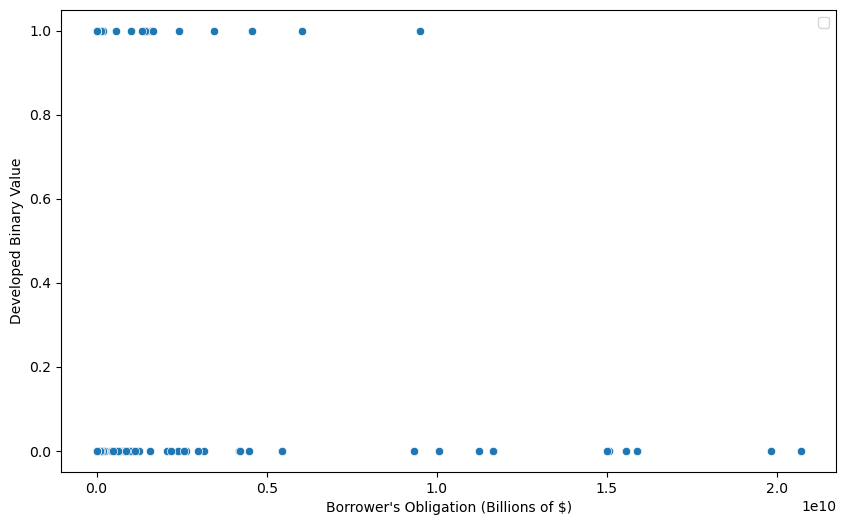

In [46]:
#plotting the data prior to the regression analysis, to get a visual
#understanding of borrower's obligation  in relation to developed/developing

plt.figure(figsize = (10, 6))
sns.scatterplot(y = gdp_debt_csv['developed'], x = gdp_debt_csv['Borrower\'s Obligation'])
plt.ylabel('Developed Binary Value')
plt.xlabel('Borrower\'s Obligation (Billions of $)')
plt.legend()

In [47]:
#fitting model and looking at coefficient
y = gdp_debt_csv['developed']
X = gdp_debt_csv[['Borrower\'s Obligation']]
X_sm = sm.add_constant(X)
b_obl_model = sm.Logit(y,X_sm).fit()
print(b_obl_model.summary())

Optimization terminated successfully.
         Current function value: 0.615077
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              developed   No. Observations:                  135
Model:                          Logit   Df Residuals:                      133
Method:                           MLE   Df Model:                            1
Date:                Sat, 02 Dec 2023   Pseudo R-squ.:                 0.02563
Time:                        22:02:09   Log-Likelihood:                -83.035
converged:                       True   LL-Null:                       -85.220
Covariance Type:            nonrobust   LLR p-value:                   0.03662
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.5563      0.200     -2.786      0.005      -0.948      -0.

In this case, the value for $e^\beta$ is approximately 1.  This means that for every dollar change in the amount of money for a country's Borrower's Obligation, we expect that the odds of a country being developed are multiplied by 1.  This is inconclusive, because it means that the odds of a country being developed stay the same regardless of any change in borrower's obligation.  As a result, our hypothesis was not true. In addition, the p-value is 0.088 which is greater than 0.05, so that means the output is not significant.

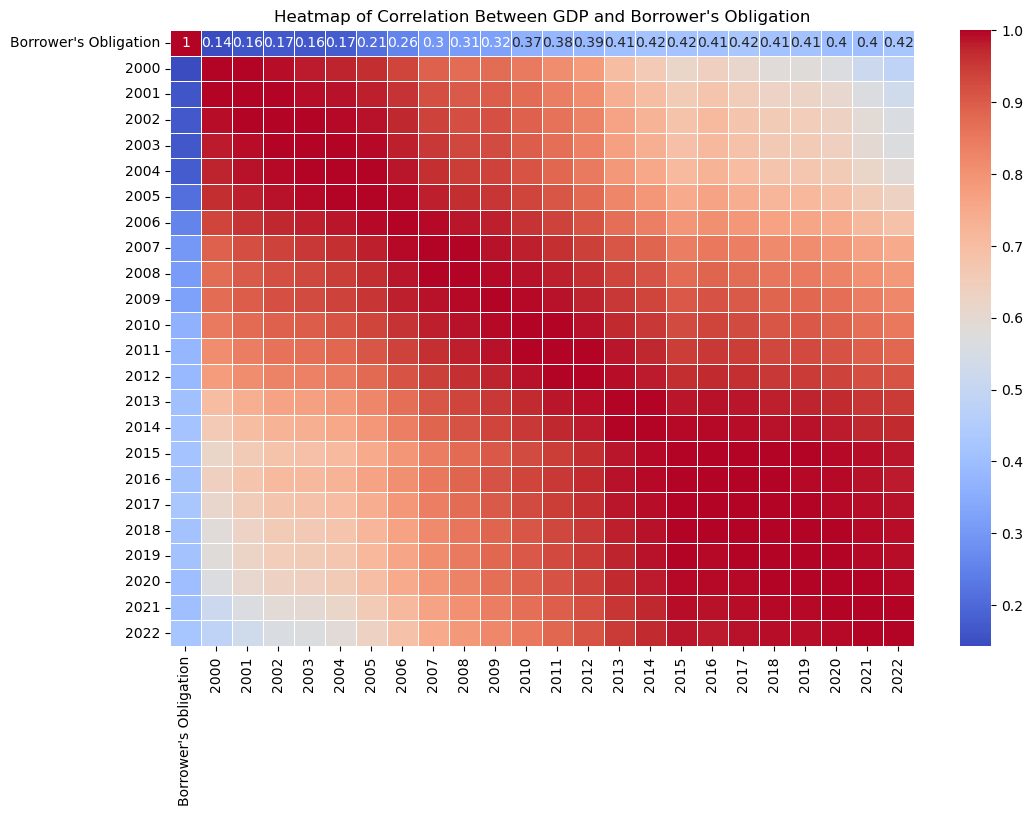

In [48]:
year_columns = [str(year) for year in range(2000, 2023)]
year_loan = ['Borrower\'s Obligation'] + year_columns

# creating a correlation matrix
correlation_matrix = gdp_dbt_dev_df[year_loan].corr()

# creating the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Correlation Between GDP and Borrower\'s Obligation')
plt.show()

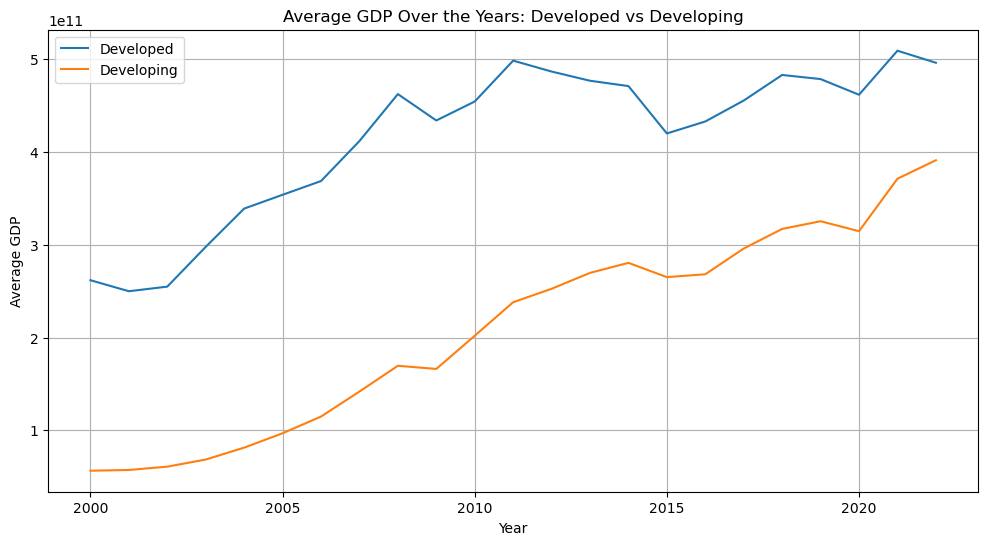

In [49]:
#plotting a line graph of the average GDP growth over the years
#for developed vs developing countries
plt.figure(figsize=(12,6))
developed_df = gdp_dbt_dev_df[gdp_dbt_dev_df['developed'] == 1.0]
developing_df = gdp_dbt_dev_df[gdp_dbt_dev_df['developed'] == 0.0]
developed_df.loc[:, '2000':'2022'].mean().plot(label='Developed')
developing_df.loc[:, '2000':'2022'].mean().plot(label='Developing')
plt.title('Average GDP Over the Years: Developed vs Developing')
plt.xlabel('Year')
plt.ylabel('Average GDP')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\adika\anaconda3\envs\info_2950\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\adika\anaconda3\envs\info_2950\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\adika\anaconda3\envs\info_2950\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\adika\anaconda3\envs\info_2950\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

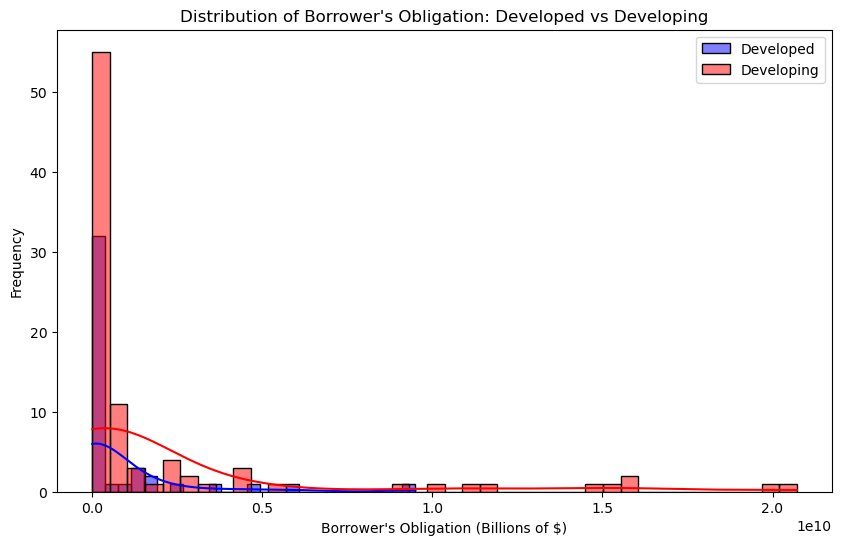

In [50]:
#analyzing the distribution of Borrower's Obligation for developed
#vs developing countries in histogram
plt.figure(figsize=(10,6))
sns.histplot(developed_df['Borrower\'s Obligation'], kde=True, 
             label='Developed', color='blue')
sns.histplot(developing_df['Borrower\'s Obligation'], kde=True, 
             label='Developing', color='red')
plt.title('Distribution of Borrower\'s Obligation: Developed vs Developing')
plt.xlabel('Borrower\'s Obligation (Billions of $)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

c:\Users\adika\anaconda3\envs\info_2950\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\adika\anaconda3\envs\info_2950\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


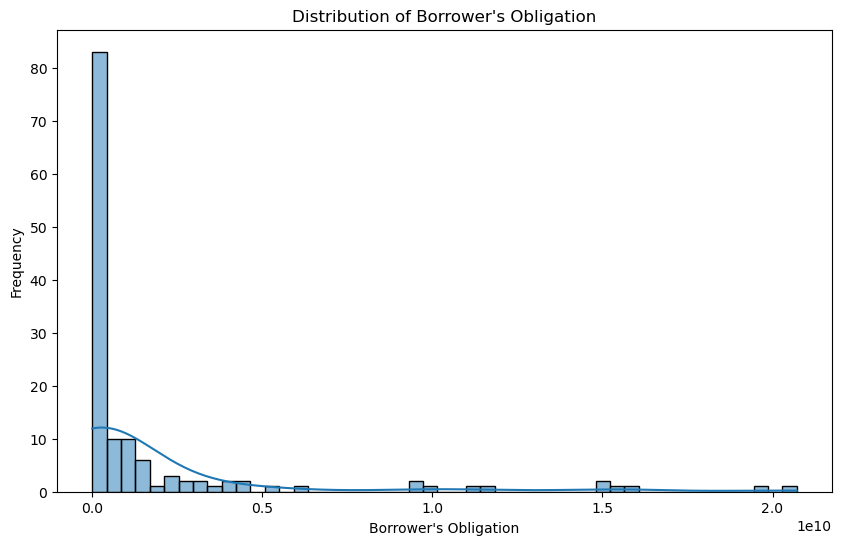

In [51]:
# analyzing the distribution of "Borrower's Obligation" (debt owed by country)
plt.figure(figsize=(10,6))
sns.histplot(gdp_dbt_dev_df['Borrower\'s Obligation'], kde=True)
plt.title('Distribution of Borrower\'s Obligation')
plt.xlabel('Borrower\'s Obligation')
plt.ylabel('Frequency')
plt.show()

c:\Users\adika\anaconda3\envs\info_2950\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\adika\anaconda3\envs\info_2950\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\adika\anaconda3\envs\info_2950\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\adika\anaconda3\envs\info_2950\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

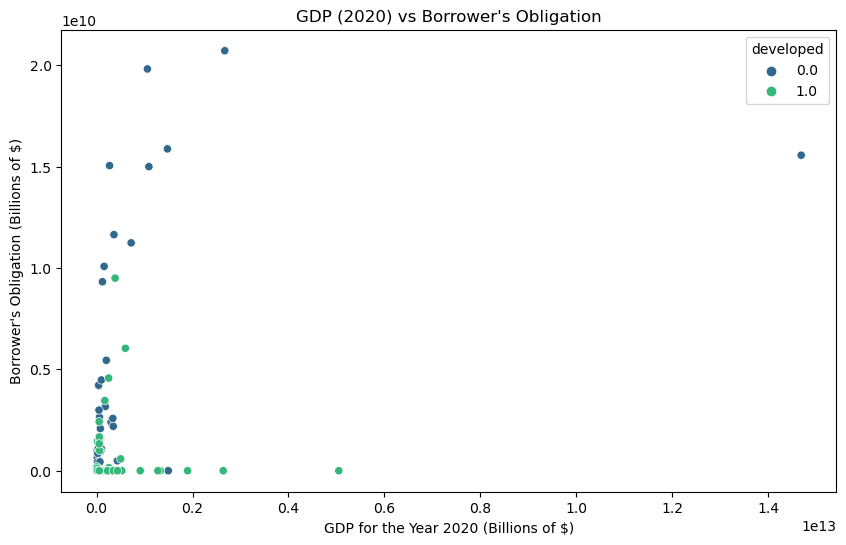

In [52]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=gdp_dbt_dev_df, y='Borrower\'s Obligation', x='2020',
                hue='developed', palette="viridis")
plt.title('GDP (2020) vs Borrower\'s Obligation')
plt.ylabel('Borrower\'s Obligation (Billions of $)')
plt.xlabel('GDP for the Year 2020 (Billions of $)')
plt.show()

### Hypothesis 2: The Higher GDP a Country Has, The More Likely it is to Have a High Value for Intellectual Property Charges

In [53]:
ip_debt_csv = pd.read_csv("./Int_Prop_Debt_Combined.csv")
print(ip_debt_csv.head(2))

   Country  Original Principal Amount  Cancelled Amount  Undisbursed Amount  \
0  Albania               2.032160e+09      1.402591e+08         746585590.2   
1  Algeria               5.911830e+09      1.605315e+09                 0.0   

   Disbursed Amount  Borrower's Obligation Country_Code  \
0      1.082344e+09            874013475.8          ALB   
1      4.306515e+09                    0.0          DZA   

                                         Series_Name     Series_Code  2000  \
0  Charges for the use of intellectual property, ...  BM.GSR.ROYL.CD   0.0   
1  Charges for the use of intellectual property, ...  BM.GSR.ROYL.CD   0.0   

   ...          2014          2015          2016          2017         2018  \
0  ...  2.188193e+07  2.457801e+07  2.316308e+07  1.313243e+07   26412466.5   
1  ...  1.439974e+08  2.500106e+08  1.528979e+08  1.472687e+08  115089900.8   

           2019          2020          2021          2022  developed  
0  3.478422e+07  3.860932e+07  3.476372e

In [54]:
data_columns = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', '2019', '2020', '2021', '2022']

ip_avg = ip_debt_csv[data_columns].mean(axis = 1)
ip_debt_csv['avg'] = ip_avg
print(ip_debt_csv.head())

gdp_avg = gdp_debt_csv[data_columns].mean(axis = 1)
gdp_debt_csv['avg'] = gdp_avg
print(gdp_debt_csv.head())

               Country  Original Principal Amount  Cancelled Amount  \
0              Albania               2.032160e+09      1.402591e+08   
1              Algeria               5.911830e+09      1.605315e+09   
2  Antigua and Barbuda               1.200000e+07      7.435746e+06   
3              Armenia               1.224900e+09      4.430277e+07   
4           Azerbaijan               3.479300e+09      5.324351e+08   

   Undisbursed Amount  Disbursed Amount  Borrower's Obligation Country_Code  \
0         746585590.2      1.082344e+09           8.740135e+08          ALB   
1                 0.0      4.306515e+09           0.000000e+00          DZA   
2             51614.0      4.512640e+06           4.012867e+06          ATG   
3         130159016.0      1.053062e+09           9.671751e+08          ARM   
4         108026863.4      2.838838e+09           1.250364e+09          AZE   

                                         Series_Name     Series_Code  \
0  Charges for the use of 

In [59]:
#fitting model and looking at coefficient
y = ip_avg
X = gdp_debt_csv[['avg']]
X_sm = sm.add_constant(X)
gdp_ip_model = sm.OLS(y,X_sm).fit()
print(gdp_ip_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8259
Date:                Sat, 02 Dec 2023   Prob (F-statistic):              0.365
Time:                        22:08:26   Log-Likelihood:                -3219.3
No. Observations:                 135   AIC:                             6443.
Df Residuals:                     133   BIC:                             6448.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.334e+09      5e+08      2.666      0.0

In this case, the value for the coefficient of the GDP variable in the linear regression is 0.005006.  This means that for every dollar change in the amount of money for a country's Gross Domestic Product is, we can expect the country's Intellectual Property Charges to increase by $0.0005.  This is an extremely small amount, but because our GDP and Intellectual Property Charge values are in the Billions, it does show an positive correlation between GDP and Intellectual Property Charge.  As a result, our hypothesis was true to an extent.

### Looking at Specific Years' Impacts on Intellectual Property Charges for Developed vs Developing Countries:

In [56]:
data_columns = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', '2019', '2020', '2021', '2022']

data_columns_with_dev = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', '2019', '2020', '2021', '2022', 'developed']

ip_years_data = ip_debt_csv[data_columns_with_dev]
ip_years_data['gdp_average'] = gdp_avg
ip_years_data.head()

ip_years_data_developed = duckdb.sql('SELECT * FROM ip_years_data WHERE developed = 1.0').df()
ip_years_data_developing = duckdb.sql('SELECT * FROM ip_years_data WHERE developed = 0.0').df()



C:\Users\adika\AppData\Local\Temp\ipykernel_18128\2794715765.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ip_years_data['gdp_average'] = gdp_avg


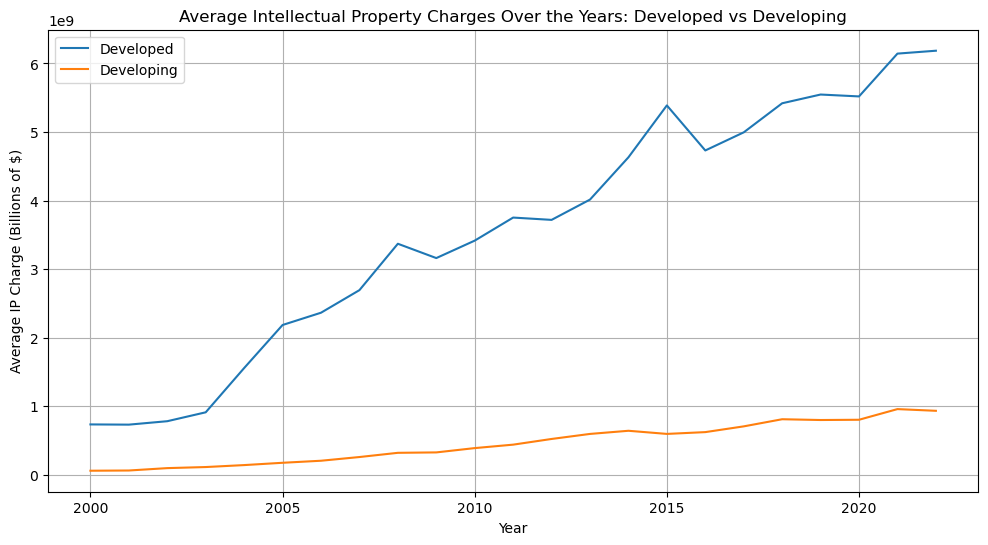

In [57]:
#average IP change over years, developed vs developing
ip_developed_df = int_prop_dbt_dev_df[int_prop_dbt_dev_df['developed'] == 1.0]
ip_developing_df = int_prop_dbt_dev_df[int_prop_dbt_dev_df['developed'] == 0.0]

plt.figure(figsize=(12,6))
ip_developed_df.loc[:, '2000':'2022'].mean().plot(label='Developed')
ip_developing_df.loc[:, '2000':'2022'].mean().plot(label='Developing')
plt.title('Average Intellectual Property Charges Over the Years: Developed'
          +' vs Developing')
plt.xlabel('Year')
plt.ylabel('Average IP Charge (Billions of $)')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation of Significance

Hypothesis 1: 
The logistic regression derived indicates that the coefficient for 'Borrower's Obligation' is very close to 0 ( around  -2.16e-10), and the odds ratio is close to 1. The odds ratio is calculated by e to the negative coefficient (e ^ -2.16e-10). This suggests that the odds of a country being developed does not significantly or necessarily change with a one dollar (USD) increase in borrower’s obligation. The p value is 0.027 

Hypothesis 2: 
The linear regression 0.0005000575461410255. Because this is a positive number we know that there is a positive relationship between Intellectual Property Changes and GDP. It is important to acknowledge that the number is extremely small meaning that there is a weak relationship between the numbers. In other words it means that for an increase in Intellectual property there might be an increase in GDP but it will not have substantial impact. As a result, it is not significantly changing. 


## Intepretation and Conclusions

- Interpretation: 

Hypothesis 1: 
The purpose of the logistic regression was to determine whether a country’s status of being developed or developing could be predicted based on the country’s borrower's obligation to the World Bank. The coefficient was -2.16015716e-10. Therefore, the odds ratio is approximately 1 as explained previously. This means that for every 1 (measured in USD dollars) increase in borrower’s obligation, the probability of a country being developed changes by a small amount. Thus, this tells us that a country’s borrower’s obligation is not a strong enough indicator of whether a country is developed or not. 

Hypothesis 2: 

The purpose of the linear regression was to determine the relationship between a country’s GDP (Gross Domestic Product measured in USD dollars) and the country’s intellectual property changes (measured in USD dollars). The coefficient was 0.0005. This means that for every 1 increase in GDP (in USD dollars), the Intellectual Property Charges are predicted to increase by 0.0005 units. This is a positive number and does indicate a relationship between the values, but it is still a very small number. This means that there might not be as much of a change in the Intellectual Property Changes as we would have expected. 

- Conclusion:

The analysis conducted above looks at data in an economic context and whether our initial hypothesis showed significance as we expected. We have now determined that the logistic regression did not show a strong relationship between Borrower’s obligation and the country’s developed or developing status. This was against our initial hypothesis. The linear relationship showed statistical significance between Intellectual Property Changes and GDP but because of how small the number is we determined that it had a small effect on the dependent variable in the scenario. As a result, both of these hypotheses emphasized the need for statistical analysis when determining coefficients and regression results. We hope that with more variables and further analysis we will be able to craft models and determine predictors for different aspects of a country’s economic landscape. 


## Limitations
Below are the key limitations that we found:

1. The data sets used cover GDP, World Bank debt, intellectual property transactions, and a list of developing and developed countries. While comprehensive, they might not account for all factors influencing a country's economic health. Variables like political stability, demographic changes, global market trends, and internal economic policies are not considered but can significantly impact GDP and debt levels.

2. The focus on data from 2000 to 2022 might miss longer-term trends and historical contexts that could influence current economic conditions. Economic policies and global events prior to 2000 could have lasting impacts not captured in this analysis.

3. The use of a binary classification (developed vs. developing) oversimplifies the spectrum of economic development. Many countries do not fit neatly into these categories, and such a binary view might overlook important nuances.

4. The analysis, primarily based on regression models, can indicate correlations but not necessarily causality. For instance, while there might be a relationship between GDP and intellectual property charges, this does not imply that one causes the other.

5. Given the diverse nature of economies and the unique circumstances of each country, the findings from this analysis may not be universally applicable. What holds true for one set of countries might not apply to others.

6. The logistic and linear regression models used have their own limitations. For instance, logistic regression might not capture complex, non-linear relationships. Similarly, linear regression assumptions (like homoscedasticity, normality of residuals) might not hold true for all the variables analyzed.

7. The datasets are secondary sources compiled by different organizations, which might have varying standards of data collection and reporting. Also, not all countries might have reported all the required data, leading to potential biases or inaccuracies in the analysis.

8. The analysis is quantitative and may not fully account for qualitative aspects like the nature of intellectual property rights enforcement, the terms of World Bank loans, or the specific economic policies of countries.

9. While the analysis might show statistical significance (like a small but non-zero correlation between GDP and intellectual property charges), the practical significance of these findings (how they translate into real-world implications) needs careful interpretation.

10. There were a few missing data that would have ‘..’ instead of 0 and NaN. As a result, we had to fill in the spaces with NaN to account for the lack of data.